# Testing the effect of scenarios, for various method candidates
- Opinion vectors are orthogonal, and another orthogonal opinion vector is added (e.g. 2→3)
- Opinion vectors are duplicated (e.g. 2→4)


In [1]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np

import seaborn as sns
import pandas as pd
import networkx as nx
import random
import scipy.stats as st

## Test variables

In [4]:
metrics = [('APD', nvd.pairwise_average), 
           ('ADM', nvd.avg_dist_to_mean), 
           ('PC', nvd.PCA_manifold), 
           ('MDS_eu', nvd.MDS_euclidean_manifold),
           ('MDS_er', nvd.MDS_er_manifold),
           ('TV', nvd.total_variation)]

metric_names = [m[0] for m in metrics]
polarization_metrics = [m[1] for m in metrics]

random_run_metrics = {'MDS_eu', 'MDS_er'}

num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

plot_width = 2
plot_height = 1.5

local_tests = [('Chains', nx.path_graph), 
                ('Complete graphs', nx.complete_graph),
                ('Communities', utils.make_community_graph)]

def qualitative_cmap(n):
    cmap = sns.husl_palette(n_colors=n, h=0.5, s=0.9, l=0.6, as_cmap=False)
    cmap = list(cmap.as_hex())
    random.shuffle(cmap)
    return ListedColormap(cmap)

    return cmap

node_size = 50
edge_width = 1.5
fig_scale = 2

# set matplotlib font to Arial with medium weight
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'medium'

experiment_folder = 'add_orthog_nodes/'

In [15]:
# qualitative_cmap(6)
n = 6
x = random.shuffle(list(sns.color_palette("Set3", n)))
x

# Addition of nodes with unique opinions

### Local Setup

Figure saved.


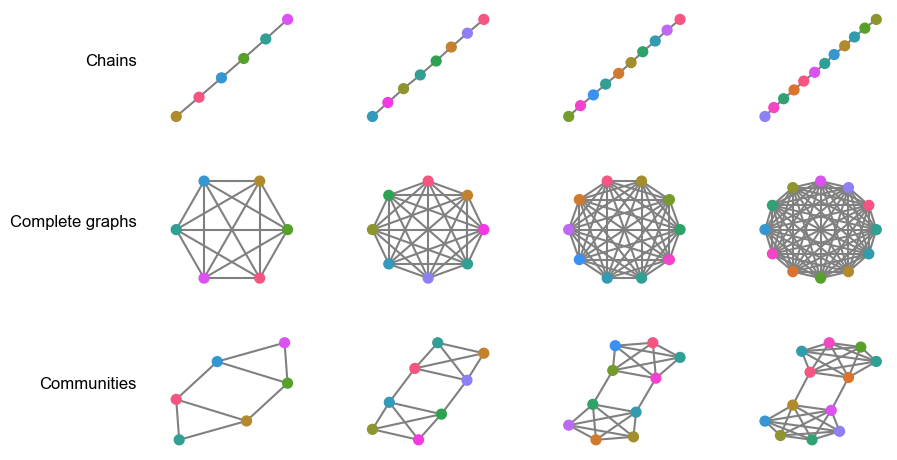

In [43]:
num_nodes_range = [6,8,10,12]

fig, ax = plt.subplots(3, len(num_nodes_range), figsize=(2*len(num_nodes_range), 5))
fig.tight_layout()

name_color = {'Chains': 'tab:red', 'Complete graphs': 'tab:blue', 'Communities': 'tab:green'}

for test_index, (name, graph_gen) in enumerate(local_tests):
    ax[test_index, 0].set_ylabel(name, rotation=0, labelpad=20, fontsize=12, ha='right')
 
    for num_nodes_index, num_nodes in enumerate(num_nodes_range):

        if name == 'Communities':
            G = graph_gen(2, num_nodes//2)
        else:
            G = graph_gen(num_nodes)
        
        pos = nx.kamada_kawai_layout(G) # seed=1, k=10, iterations=1000

        # hide subplot axes lines
        for direction in ['top','right','left','bottom']:
            ax[test_index, num_nodes_index].spines[direction].set_visible(False)

        cmap = qualitative_cmap(num_nodes)

        nx.draw_networkx_nodes(G, ax=ax[test_index, num_nodes_index], pos=pos, node_size=node_size, cmap=cmap, node_color=range(num_nodes))
        nx.draw_networkx_edges(G, ax=ax[test_index, num_nodes_index], edge_color='gray', pos=pos, width=edge_width)
# nx.draw(G, ax=ax[test_index, num_nodes_index], with_labels=False, node_size=25, edge_color='dimgray', node_color=name_color[name])

utils.save_figure("local_setup", experiment_folder, overwrite=True)

### Local Results

Figure saved.


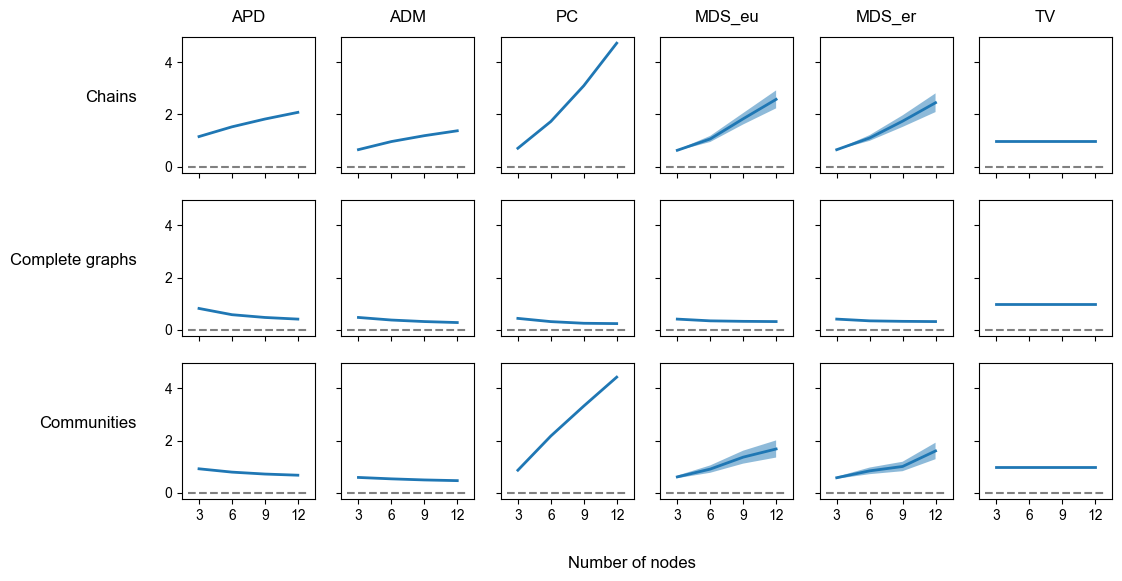

In [5]:
fig, ax = plt.subplots(len(local_tests), len(metrics), figsize=(len(metrics)*fig_scale, len(local_tests)*fig_scale), sharey=True, sharex=True)

# Set ticks for all x axes (since they are shared)
ax[0, 0].set_xticks(num_nodes_range)

for test_index, (graph_name, graph_type) in enumerate(local_tests):

    for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

        # Initialize arrays to store the means and confidence intervals of repeated runs
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_opinions in enumerate(num_nodes_range):

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=2, nodes_per_comm=num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions*2)], data=np.identity(num_opinions*2))
                else:
                    G = graph_type(num_opinions)
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))

                
                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)
                run_pols[run] = polarization

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[test_index, metric_index].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[test_index, metric_index].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[test_index, metric_index].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed', label='Expected')

        # Add title to the first row
        if test_index == 0:
            ax[test_index, metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

        # Add title to the first column
        if metric_index == 0:
            ax[test_index, metric_index].set_ylabel(graph_name, rotation=0, labelpad=20, fontsize=12, ha='right')


# fig.suptitle(graph_name, y=1.2, fontsize=16)

# fig.supylabel('Polarization', x=0.08)
fig.supxlabel('Number of nodes', fontsize=12, y=-0.01)

utils.save_figure("local_res", experiment_folder)

### Global Setup

In [ ]:
num_nodes_range = [6,8,10,12]

fig, ax = plt.subplots(3, len(num_nodes_range), figsize=(2*len(num_nodes_range), 5))
fig.tight_layout()

name_color = {'Chains': 'tab:red', 'Complete graphs': 'tab:blue', 'Communities': 'tab:green'}

for test_index, (name, graph_gen) in enumerate(local_tests):
    ax[test_index, 0].set_ylabel(name, rotation=0, labelpad=20, fontsize=12, ha='right')
 
    for num_nodes_index, num_nodes in enumerate(num_nodes_range):

        if name == 'Communities':
            G = graph_gen(2, num_nodes//2)
        else:
            G = graph_gen(num_nodes)
        
        pos = nx.kamada_kawai_layout(G) # seed=1, k=10, iterations=1000

        # hide subplot axes lines
        for direction in ['top','right','left','bottom']:
            ax[test_index, num_nodes_index].spines[direction].set_visible(False)

        cmap = qualitative_cmap(num_nodes)

        nx.draw_networkx_nodes(G, ax=ax[test_index, num_nodes_index], pos=pos, node_size=node_size, cmap=cmap, node_color=range(num_nodes))
        nx.draw_networkx_edges(G, ax=ax[test_index, num_nodes_index], edge_color='gray', pos=pos, width=edge_width)
# nx.draw(G, ax=ax[test_index, num_nodes_index], with_labels=False, node_size=25, edge_color='dimgray', node_color=name_color[name])

utils.save_figure("local_setup", experiment_folder, overwrite=True)

### Global Results

# Converting neutral community to third orthogonal opinion

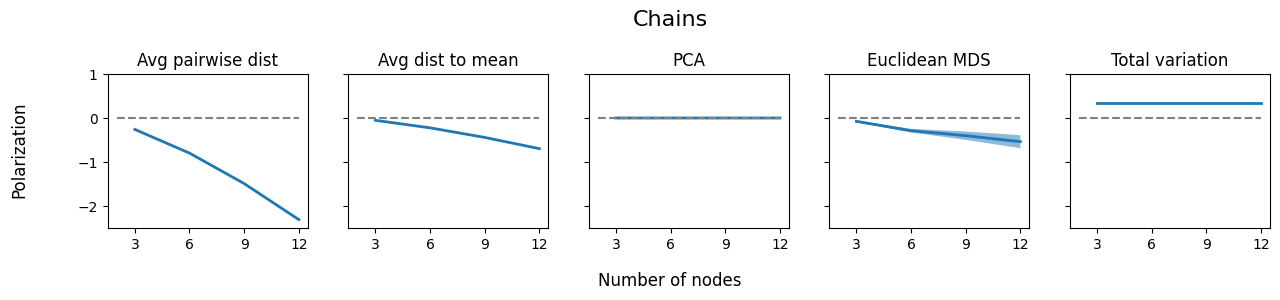

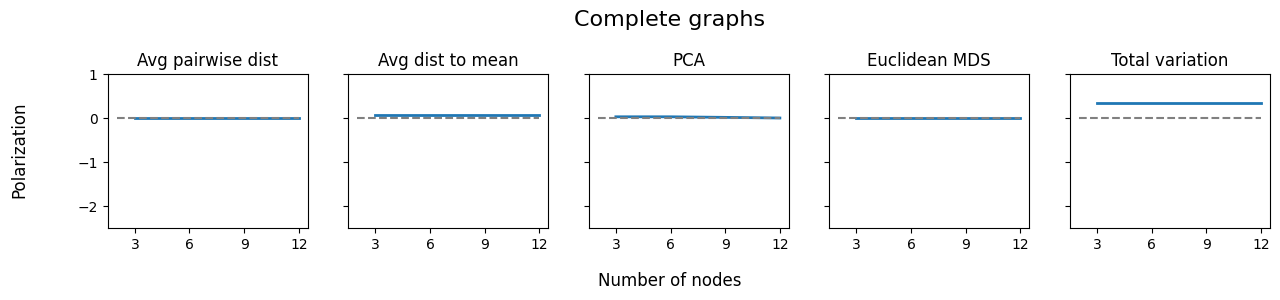

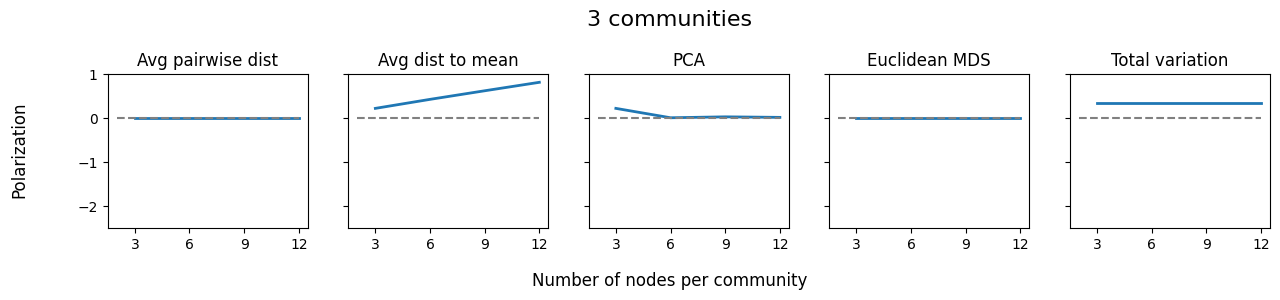

In [4]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_type == utils.make_community_graph:
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                # neutral opinion polarization
                o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                                    np.array([(0,0)]*nodes_per_comm),
                                                                    np.array([(0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                neutral_polarization = polarization_metric(tensor)

                # third opinion polarization
                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                            np.array([(0,1,0)]*nodes_per_comm),
                                                                            np.array([(0,0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                third_polarization = polarization_metric(tensor)

                difference = third_polarization - neutral_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_ylim(-2.5, 1)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

# Duplicating one or more opinion vectors

Note: for some reason it makes no difference whether I duplicate one or 3 opinions, is it a bug?

### Duplicating all 3 orthogonal opinions

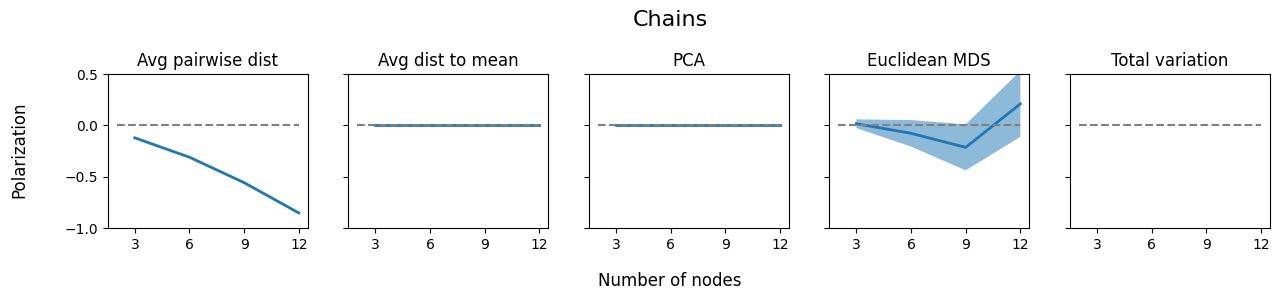

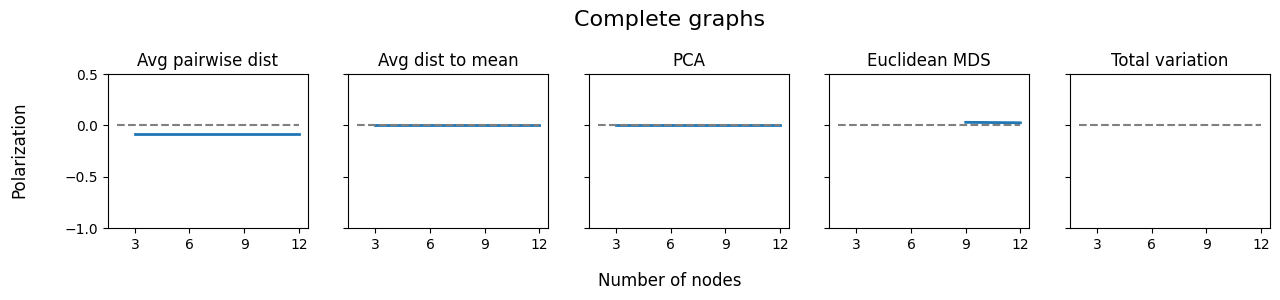

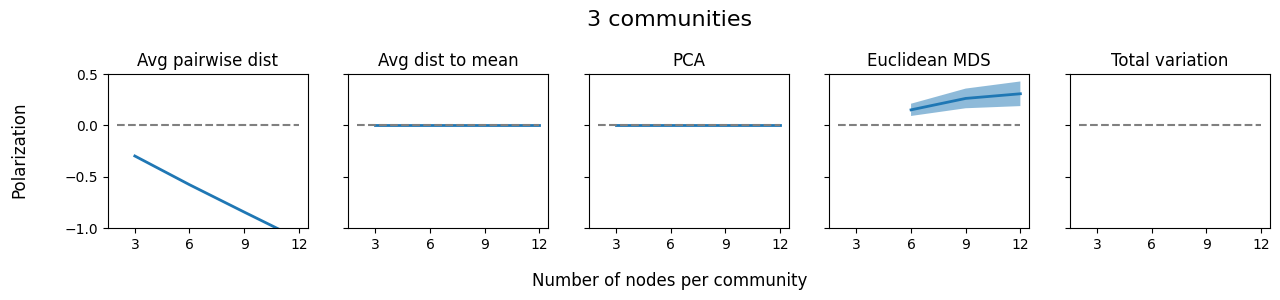

In [8]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 40

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_type == utils.make_community_graph:
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

                tensor = nvd.make_tensor(G, o)
                unique_polarization = polarization_metric(tensor)

                # duplicate o
                dup_o = pd.concat([o, o], axis=1)
                # rename columns
                dup_o.columns = ['o'+str(i) for i in range(len(dup_o.columns))]

                dup_tensor = nvd.make_tensor(G, dup_o)
                duplicate_polarization = polarization_metric(dup_tensor)

                difference = duplicate_polarization - unique_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)
        ax[i].set_ylim(-1, 0.5)

    if graph_type == utils.make_community_graph:
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

### Duplicating 1 of 3 orthogonal opinions

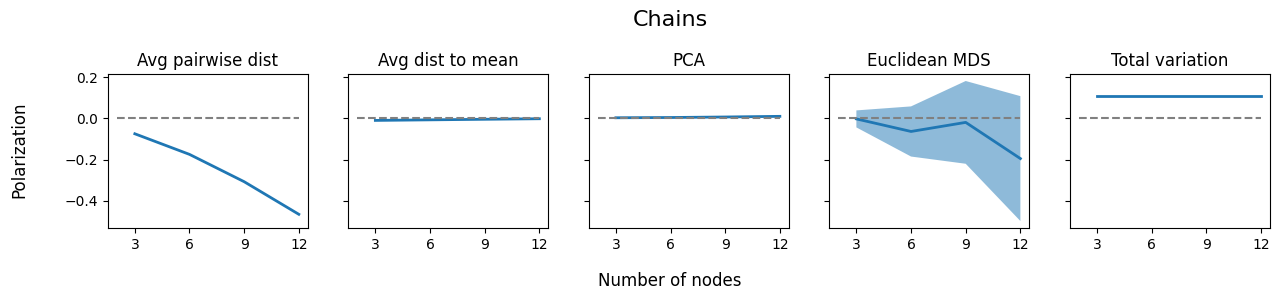

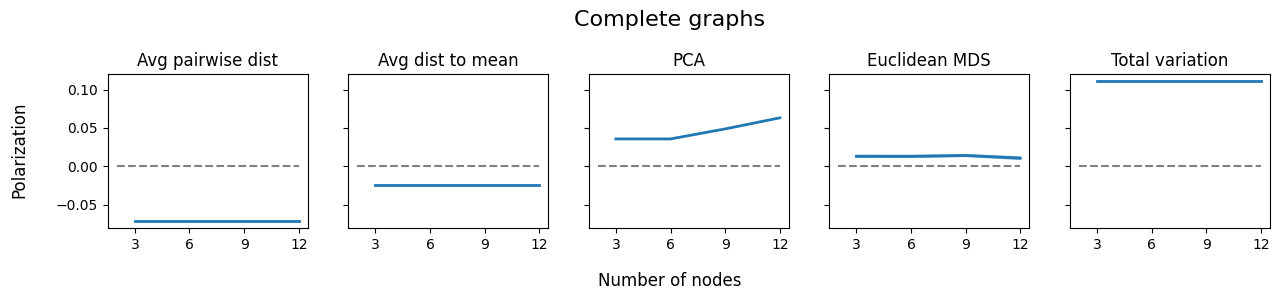

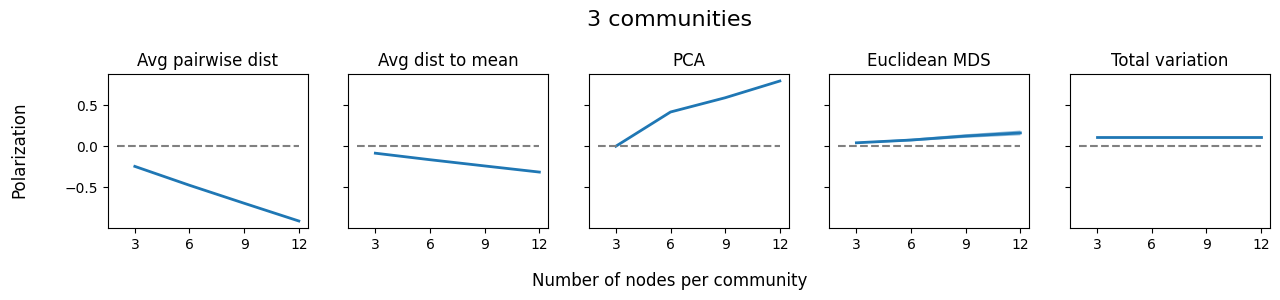

In [6]:
num_nodes_range = range(3, 13, 3)
num_communities = 3
num_runs = 50

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph),
                               ('3 communities', utils.make_community_graph)]:

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(3*len(polarization_metrics), 2), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):
            if graph_name == '3 communities':
                nodes_per_comm = num_nodes
            else:
                nodes_per_comm = num_nodes//num_communities
    
            neutral_polarization = 0
            third_polarization = 0

            if metric_name not in random_run_metrics:
                curr_num_runs = 1
            else:
                curr_num_runs = num_runs
        
            run_pols = np.zeros(curr_num_runs)
            
            for run in range(curr_num_runs):
                
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=num_communities, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

                tensor = nvd.make_tensor(G, o)
                unique_polarization = polarization_metric(tensor)

                # duplicate last column of o
                dup_o = pd.concat([o, o.iloc[:, -1]], axis=1)

                dup_tensor = nvd.make_tensor(G, dup_o)
                duplicate_polarization = polarization_metric(dup_tensor)

                difference = duplicate_polarization - unique_polarization

                run_pols[run] = difference

            means[opinion_index] = np.mean(run_pols)

            if metric_name in random_run_metrics:

                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, len(run_pols))

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

        ax[i].plot(num_nodes_range, means, lw=2)

        if metric_name in random_run_metrics:
            ax[i].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1], colors='gray', linestyles='dashed')
        ax[i].set_title(metric_name)
        # set xticks to num_nodes_range
        ax[i].set_xticks(num_nodes_range)

    if graph_name == '3 communities':
        fig.supxlabel('Number of nodes per community', y=-0.2)
    else:
        fig.supxlabel('Number of nodes', y=-0.2)
    fig.supylabel('Polarization', x=0.06)
    fig.suptitle(graph_name, y=1.2, fontsize=16)

In [7]:
def plot_test(num_opinions_range, n_nodes, n_comms, p_out, intercon, polarization_metrics, metric_names, plot_title, plot_xlabel, plot_ylabel, opinion_type, num_runs=10):
    """
    Plot the polarization of a SBM graph with different number of opinions and different polarization metrics.
    
    num_opinions_range: range, range of number of opinions to test
    num_runs: int, number of runs random initializations for each test
    opinion_types: list, list of opinion types to test
    """

    if not n_nodes % n_comms == 0:
        raise ValueError(f'n_nodes={n_nodes} not divisible by n_comms={n_comms}')
    nodes_per_comm = n_nodes//n_comms

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        pols = np.array([])
        pol_lower_conf = np.array([])
        pol_higher_conf = np.array([])

        for num_opinions in num_opinions_range:

            run_pols = np.zeros(num_runs)

            for run in range(num_runs):

                G = SBM_graph(n_nodes, n_comms, p_out, intercon, nodes_per_comm)
    

                if opinion_type == 'unique':
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
                elif opinion_type == 'orthogonal':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                                np.array([(0,1,0)]*nodes_per_comm),
                                                                                np.array([(0,0,1)]*nodes_per_comm))))
                elif opinion_type == 'correlated':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,1,0)]*nodes_per_comm),
                                                                                np.array([(0,1,1)]*nodes_per_comm),
                                                                                np.array([(1,0,1)]*nodes_per_comm))))
                else:
                    raise ValueError(f'opinion_type={opinion_type} not valid. Must be one of "unique", "orthogonal", "correlated".')

                tensor = nvd.make_tensor(G, o)
                Linv = nvd._Linv(tensor)

                polarization = polarization_metric(tensor, Linv=Linv)
                run_pols[run] = polarization

            # Calculate the mean polarization of num_runs runs
            pols = np.append(pols, np.mean(run_pols))  

            # Calculate the 95% confidence intervals of the mean polarization
            lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))
            pol_lower_conf = np.append(pol_lower_conf, lower_conf)
            pol_higher_conf = np.append(pol_higher_conf, higher_conf)

        ax[i].plot(num_opinions_range, pols, lw=2)
        ax[i].fill_between(num_opinions_range, pol_higher_conf, pol_lower_conf, alpha=.5, linewidth=0)  # Shade the 95% confidence interval around the mean
        ax[i].set_title(metric_name)

    fig.suptitle(plot_title, y=1.1, fontsize=16)
    fig.supxlabel(plot_xlabel, y=-0.1)
    fig.supylabel(plot_ylabel, x=0.05);